# Trend Following Strategy from Andreas Clenow

This notebook implements the trend following strategy from the book "Following the trend" by Andreas Clenow. This strategy is basically Donchian breakouts plus MA trend filter, so it is very similar to the original turtle strategy in the book "Way of the Turtle" by Curtis Faith.

* Trend Filter: MA50>MA100, long only; MA50<MA100, short only.
* Entry rule:
    1. Close > recent 50 days max price, open long
    1. Close < recent 50 days min price, open short
* Exit rule:
    1. Close <= recent 25 days min price, close long. If the close price drops below the minimum of recent 25 days price, close long positions.
    1. Close >= recent 25 days max price, close short. If the close price rises above the maximum of recent 25 days price, close short positions.
* Trailing Stop: 3 ATR<sub>100</sub>.
* Position sizing: 
    1. Allocate 0.2% cash to each asset, i.e., risk factor is 0.002.
    1. contract_number =$\dfrac{0.002 \times cash}{ATR_{100} \times price}$

In [1]:
%matplotlib inline

from typing import Dict, List, Tuple, Union

import os
import multiprocessing
from tqdm.contrib.concurrent import process_map 
import backtrader as bt
import pandas as pd
from dask import bag as db
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt

## 1. Reading Data

In [2]:
BAR_SIZE = 180000 # 3 minute
TIME_BAR_DIR = f'/data/bars/TimeBar/{BAR_SIZE}'

In [3]:
from utils import read_bars

In [4]:
time_bars = read_bars(f'/data/bars/TimeBar/{BAR_SIZE}/TimeBar.{BAR_SIZE}.Binance.Swap.BTC_USDT.csv')

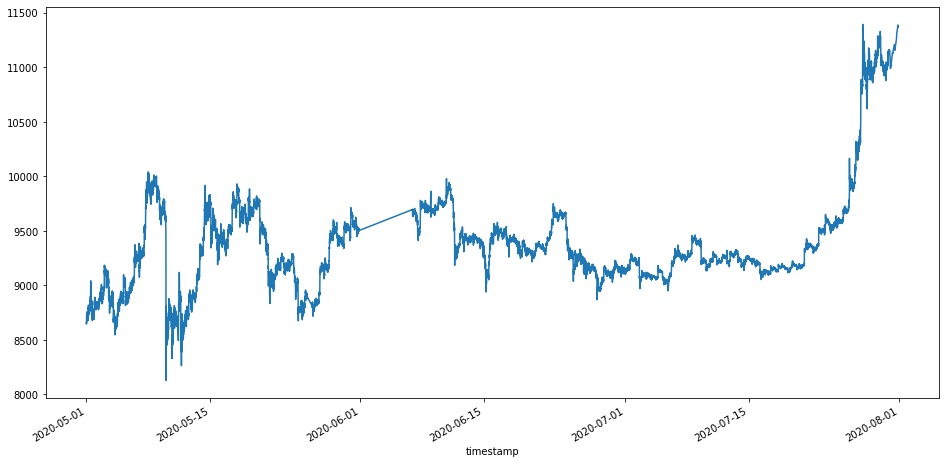

In [5]:
time_bars['vwap'].plot(figsize=(16, 8))

**They look almost the same!! There must be some cointegration.**

## 2. The Strategy

In [6]:
class DonchianChannelsIndicator(bt.Indicator):
    '''Donchian channel.'''

    alias = ('DCH', 'DonchianChannel',)

    lines = ('dcm', 'dch', 'dcl',)  # dc middle, dc high, dc low

    params = (
        ('period', 20), # lookback period
    )

    plotinfo = dict(subplot=False)  # plot along with data
    plotlines = dict(
        dcm=dict(ls='--'),  # dashed line
        dch=dict(_samecolor=True),  # use same color as prev line (dcm)
        dcl=dict(_samecolor=True),  # use same color as prev line (dch)
    )

    def __init__(self):
        super().__init__()
        self.addminperiod(self.params.period + 1)
        self.lines.dch = bt.indicators.Highest(self.data.high(-1), period=self.params.period)
        self.lines.dcl = bt.indicators.Lowest(self.data.low(-1), period=self.params.period)
        self.lines.dcm = (self.lines.dch + self.lines.dcl) / 2.0  # avg of the above

In [7]:
class ClenowTrendFollowingStrategy(bt.Strategy):
    """The trend following strategy from the book "Following the trend" by Andreas Clenow."""
    alias = ('ClenowTrendFollowing',)

    params = (
        ('trend_filter_fast_period', 50),
        ('trend_filter_slow_period', 100),
        ('fast_donchian_channel_period', 25),
        ('slow_donchian_channel_period', 50),
        ('trailing_stop_atr_period', 100),
        ('trailing_stop_atr_count', 3),
        ('risk_factor', 0.002)
    )

    def __init__(self):
        self.trend_filter_fast = bt.indicators.EMA(period=self.params.trend_filter_fast_period)
        self.trend_filter_slow = bt.indicators.EMA(period=self.params.trend_filter_slow_period)
        self.dc_fast = DonchianChannelsIndicator(period=self.params.fast_donchian_channel_period)
        self.dc_slow = DonchianChannelsIndicator(period=self.params.slow_donchian_channel_period)
        self.atr = bt.indicators.ATR(period=self.params.trailing_stop_atr_period)
        self.order = None  # the pending order
        # For trailing stop loss
        self.sl_order = None # trailing stop order
        self.sl_price = None
        self.max_price = None # track the highest price after opening long positions
        self.min_price = None # track the lowest price after opening short positions

    def next(self):
        # self.dc_slow.dcl <= self.dc_fast.dcl <= self.dc_fast.dch <= self.dc_slow.dch
        assert self.dc_slow.dcl <= self.dc_fast.dcl
        assert self.dc_fast.dcl <= self.dc_fast.dch
        assert self.dc_fast.dch <= self.dc_slow.dch

        if not self.position: # Entry rules
            assert self.position.size == 0
            
            # Position size rule
            max_loss = self.broker.get_cash() * self.p.risk_factor # cash you afford to loss
            position_size = max_loss / self.atr[0]

            if self.data.close > self.dc_slow.dch:
                if self.trend_filter_fast > self.trend_filter_slow: # trend filter
                    if self.order:
                        self.broker.cancel(self.order)
                    else:
                        # Entry rule 1
                        self.order = self.buy(price=self.data.close[0], size=position_size, exectype=bt.Order.Limit) 
                        self.max_price = self.data.close[0]
            elif self.data.close < self.dc_slow.dcl:
                if self.trend_filter_fast  < self.trend_filter_slow: # trend filter
                    if self.order:
                        self.broker.cancel(self.order)
                    else:
                        # Entry rule 2
                        self.order = self.sell(price=self.data.close[0], size=position_size, exectype=bt.Order.Limit) 
                        self.min_price = self.data.close[0]
        else:
            assert self.position.size
            # assert self.order is None

            # Exit rules
            if self.position.size > 0:
                # Exit rule 1
                if self.data.close < self.dc_fast.dcl:
                    self.order = self.order_target_value(target=0.0, exectype=bt.Order.Limit, price=self.data.close[0])
                    return
            else:
                # Exit rule 2
                if self.data.close > self.dc_fast.dch:
                    self.order = self.order_target_value(target=0.0, exectype=bt.Order.Limit, price=self.data.close[0])
                    return

            # Trailing stop loss
            trail_amount = self.atr[0] * self.p.trailing_stop_atr_count
            if self.position.size > 0:
                self.max_price = self.data.close[0] if self.max_price is None else max(self.max_price, self.data.close[0])
                if self.sl_price is None or self.sl_price < self.max_price - trail_amount:
                    self.sl_price = self.max_price - trail_amount # increase trailing price
                    if self.sl_order:
                        self.broker.cancel(self.sl_order)
                    else:
                        self.sl_order = self.order_target_value(target=0.0, exectype=bt.Order.Stop, price=self.sl_price)
            elif self.position.size < 0:
                self.min_price = self.data.close[0] if self.min_price is None else min(self.min_price, self.data.close[0])
                if self.sl_price is None or self.sl_price > self.min_price + trail_amount:
                    self.sl_price = self.min_price + trail_amount # decrease trailing price
                    if self.sl_order:
                        self.broker.cancel(self.sl_order)
                    else:
                        self.sl_order = self.order_target_value(target=0.0, exectype=bt.Order.Stop, price=self.sl_price)

    def notify_order(self, order):
        if order.status in [order.Created, order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # print logs here

        # Write down: no pending order
        if order.exectype == bt.Order.Stop:
            self.sl_order = None
        else:
            self.order = None

## 3. Running the strategy

In [8]:
LEVERAGE = 1 # No leverage in backtesting
BINANCE_SWAP_TAKER_FEE = 0.0004
INITIAL_CASH = 20000.0 # dollars

In [9]:
from utils import CryptoSpotCommissionInfo, CryptoContractCommissionInfo, CryptoPandasData

def strategy_demo():
    cerebro = bt.Cerebro(maxcpus=1)
    cerebro.addstrategy(ClenowTrendFollowingStrategy)

    data_feed = CryptoPandasData(dataname=time_bars, timeframe=bt.TimeFrame.Minutes, compression=BAR_SIZE//(1000*60), name='Binance-Swap-BTC_USDT')
    cerebro.adddata(data_feed)

    cerebro.broker.setcash(INITIAL_CASH)
    # https://www.backtrader.com/blog/posts/2016-12-06-shorting-cash/shorting-cash/
    cerebro.broker.set_shortcash(False)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.broker.addcommissioninfo(CryptoContractCommissionInfo(commission=BINANCE_SWAP_TAKER_FEE, mult=LEVERAGE))

    cerebro.addsizer(bt.sizers.PercentSizer, percents=100)

    cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, compression=1, factor=365, annualize=True)
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addanalyzer(bt.analyzers.Returns, timeframe=bt.TimeFrame.Days, compression=1, tann=365)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.NoTimeFrame)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.NoTimeFrame, data=data_feed, _name='buyandhold')

    results = cerebro.run()
    assert len(results) == 1

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print(f'Number of trades: {results[0].analyzers.ta.get_analysis().total.total}')
    print('PnL: %.2f' % (results[0].analyzers.ta.get_analysis().pnl.net.total,))
    print('PnL: %.2f' % (cerebro.broker.getvalue()-INITIAL_CASH,))
    print('Sharpe Ratio: ', results[0].analyzers.sharperatio.get_analysis()['sharperatio'])
    print('CAGR: %.2f%%' % (results[0].analyzers.returns.get_analysis()['ravg'] * 100,))
    print('Total return: %.2f%%' % (list(results[0].analyzers.timereturn.get_analysis().values())[0] * 100,))
    print('Max Drawdown: %.2f%%' % results[0].analyzers.drawdown.get_analysis().max.drawdown)
    print('Buy and Hold: {0:.2f}%'.format(list(results[0].analyzers.buyandhold.get_analysis().values())[0] * 100))

    plt.rcParams['figure.figsize'] = (16, 8)
    cerebro.plot(iplot=False)

    return results[0]

Starting Portfolio Value: 20000.00
Final Portfolio Value: 19374.90
Number of trades: 90
PnL: -625.10
PnL: -625.10
Sharpe Ratio:  -0.5014549670591454
CAGR: -0.04%
Total return: -3.13%
Max Drawdown: 14.08%
Buy and Hold: 31.83%


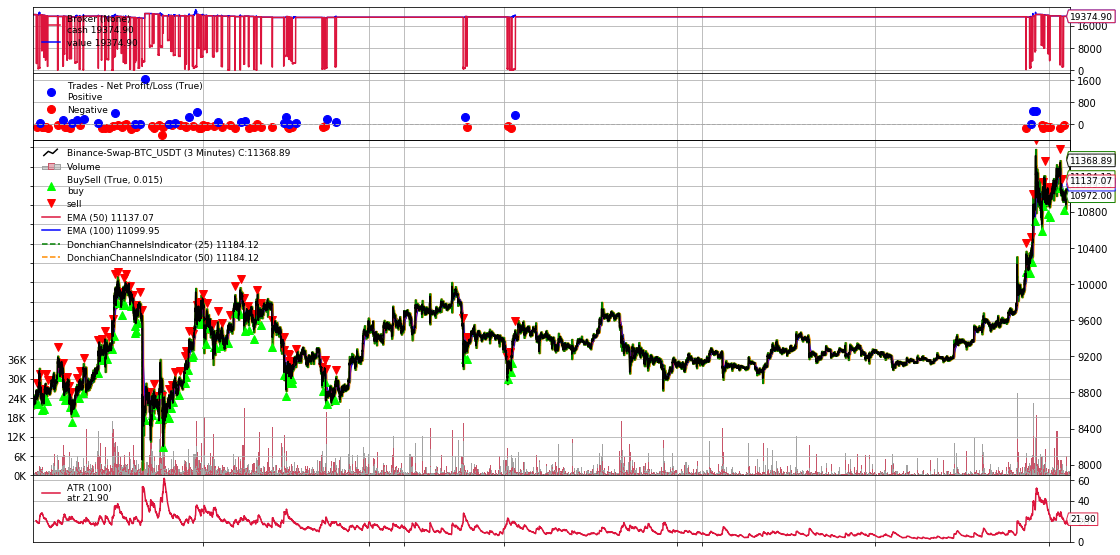

In [10]:
result = strategy_demo()

**This strategy doesn't beat the Buy&Hold benchmark, next step we're going to optimize its parameters.**

## 4. Searching for Optimal Parameters with Backtesting

In [11]:
def run_strategy(
    params: Dict[str, Union[float, int]] = {
        'trend_filter_fast_period': 50,
        'trend_filter_slow_period': 100,
        'fast_donchian_channel_period': 25,
        'slow_donchian_channel_period': 50,
        'trailing_stop_atr_period': 100,
        'trailing_stop_atr_count': 3,
        'risk_factor': 0.002
    }
):
    cerebro = bt.Cerebro(maxcpus=1)
    cerebro.addstrategy(ClenowTrendFollowingStrategy, 
                        trend_filter_fast_period=params['trend_filter_fast_period'],
                        trend_filter_slow_period = params['trend_filter_slow_period'],
                        fast_donchian_channel_period = params['fast_donchian_channel_period'],
                        slow_donchian_channel_period = params['slow_donchian_channel_period'],
                        trailing_stop_atr_period = params['trailing_stop_atr_period'],
                        trailing_stop_atr_count = params['trailing_stop_atr_count'],
                        risk_factor = params['risk_factor'])

    data_feed = CryptoPandasData(dataname=time_bars, timeframe=bt.TimeFrame.Minutes, compression=BAR_SIZE//(1000*60), name='Binance-Swap-BTC_USDT')
    cerebro.adddata(data_feed)

    cerebro.broker.setcash(INITIAL_CASH)
    # https://www.backtrader.com/blog/posts/2016-12-06-shorting-cash/shorting-cash/
    cerebro.broker.set_shortcash(False)

    cerebro.broker.addcommissioninfo(CryptoContractCommissionInfo(commission=BINANCE_SWAP_TAKER_FEE, mult=LEVERAGE))

    cerebro.addsizer(bt.sizers.PercentSizer, percents=100)

    cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, compression=1, factor=365, annualize=True)
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addanalyzer(bt.analyzers.Returns, timeframe=bt.TimeFrame.Days, compression=1, tann=365)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.NoTimeFrame)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.NoTimeFrame, data=data_feed, _name='buyandhold')

    results = cerebro.run()
    assert len(results) == 1

    stats = {
        # 'PnL': list(results[0].analyzers.timereturn.get_analysis().values())[0],
        'PnL': cerebro.broker.getvalue()/INITIAL_CASH-1,
        'BnH': list(results[0].analyzers.buyandhold.get_analysis().values())[0],
        'Sharpe_Ratio': results[0].analyzers.sharperatio.get_analysis()['sharperatio'],
        'CARG': results[0].analyzers.returns.get_analysis()['ravg'],
        'Max_Drawdown': results[0].analyzers.drawdown.get_analysis().max.drawdown/100,
        'num_trades': results[0].analyzers.ta.get_analysis().total.total,
    }
    return {**params, **stats}

In [12]:
def grid_search()->pd.DataFrame:
    params_list = []
    
    for fast_donchian_channel_period in range(30, 40):
        for m1 in range(2, 5):
            for m2 in range(2, 5):
                for atr_count in range(3, 6):
                    params = {
                    'trend_filter_fast_period': fast_donchian_channel_period * m1,
                    'trend_filter_slow_period': fast_donchian_channel_period * m1 * m2,
                    'fast_donchian_channel_period': fast_donchian_channel_period,
                    'slow_donchian_channel_period': fast_donchian_channel_period * m1,
                    'trailing_stop_atr_period': fast_donchian_channel_period * m1 * m2,
                    'trailing_stop_atr_count': atr_count,
                    'risk_factor': 0.002
                    }
                    params_list.append(params)

#     with ProgressBar(): # Backtrader is not compatible with Dask ???
#         stats = db.from_sequence(params_list).map(run_strategy).compute()

#     with multiprocessing.Pool(os.cpu_count()) as p:
#         stats = p.map(run_strategy, params_list)

    stats = process_map(run_strategy, params_list, max_workers=os.cpu_count())
    
    df = pd.DataFrame(stats)
    df.sort_values('Sharpe_Ratio', ascending=False, inplace=True)
    return df

In [13]:
df = grid_search()

In [14]:
df

,trend_filter_fast_period,trend_filter_slow_period,fast_donchian_channel_period,slow_donchian_channel_period,trailing_stop_atr_period,trailing_stop_atr_count,risk_factor,PnL,BnH,Sharpe_Ratio,CARG,Max_Drawdown,num_trades
105,132,528,33,132,528,3,0.002,0.095328,0.318345,1.266929,0.001047,0.104778,49
106,132,528,33,132,528,4,0.002,0.087661,0.318345,1.203034,0.000966,0.101609,47
107,132,528,33,132,528,5,0.002,0.075158,0.318345,1.041008,0.000833,0.120998,45
81,66,132,33,66,132,3,0.002,0.049827,0.318345,0.910052,0.000559,0.102365,70
78,128,512,32,128,512,3,0.002,0.059984,0.318345,0.858471,0.000670,0.126583,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,96,192,32,96,192,3,0.002,-0.155084,0.318345,-3.876828,-0.001937,0.216625,64
144,105,210,35,105,210,3,0.002,-0.159757,0.318345,-3.885906,-0.002001,0.210423,60
117,102,204,34,102,204,3,0.002,-0.165313,0.318345,-4.034089,-0.002077,0.216259,61
66,96,288,32,96,288,3,0.002,-0.147575,0.318345,-4.037210,-0.001835,0.150910,60


In [15]:
df.sort_values('PnL', ascending=False)

,trend_filter_fast_period,trend_filter_slow_period,fast_donchian_channel_period,slow_donchian_channel_period,trailing_stop_atr_period,trailing_stop_atr_count,risk_factor,PnL,BnH,Sharpe_Ratio,CARG,Max_Drawdown,num_trades
105,132,528,33,132,528,3,0.002,0.095328,0.318345,1.266929,0.001047,0.104778,49
106,132,528,33,132,528,4,0.002,0.087661,0.318345,1.203034,0.000966,0.101609,47
107,132,528,33,132,528,5,0.002,0.075158,0.318345,1.041008,0.000833,0.120998,45
15,90,360,30,90,360,3,0.002,0.062756,0.318345,0.854419,0.000700,0.115113,56
78,128,512,32,128,512,3,0.002,0.059984,0.318345,0.858471,0.000670,0.126583,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,105,210,35,105,210,5,0.002,-0.184392,0.318345,-3.132246,-0.002343,0.222338,61
65,96,192,32,96,192,5,0.002,-0.185876,0.318345,-3.531070,-0.002364,0.221816,63
91,99,198,33,99,198,4,0.002,-0.186519,0.318345,-3.469521,-0.002373,0.224359,66
119,102,204,34,102,204,5,0.002,-0.193077,0.318345,-3.490839,-0.002466,0.225699,62


## References

* [Orders - Backtrader](https://www.backtrader.com/docu/order/)
* [Trading Cryptocurrency Fractional Sizes in backtrader](https://www.backtrader.com/blog/posts/2019-08-29-fractional-sizes/fractional-sizes/)
* [Shorting the cash - Backtrader](https://www.backtrader.com/blog/posts/2016-12-06-shorting-cash/shorting-cash/)
* [Commission Schemes - Backtrader](https://www.backtrader.com/docu/commission-schemes/commission-schemes/)
* [Difference between leverage and multi - Backtrader Community](https://community.backtrader.com/topic/729/difference-between-leverage-and-multi)
* [Forex trading leverage settings in backtrader - Backtrader Community](https://community.backtrader.com/topic/1309/forex-trading-leverage-settings-in-backtrader)
* [How to initialize bt.analyzers.SharpeRatio? - Backtrader Community](https://community.backtrader.com/topic/2747/how-to-initialize-bt-analyzers-sharperatio)
* [How to close current position at the end of backtest? - Backtrader Community](https://community.backtrader.com/topic/1156/how-to-close-current-position-at-the-end-of-backtest)